In [1]:
import numpy as np

class SimplePostureBandit:
    def __init__(self, k=5, iterations=200, change_probability=0.3, seed=22):
        self.k = k  # Number of actions
        self.iterations = iterations
        self.actions = ['up', 'down', 'right', 'left', 'stay']
        self.q_values = np.zeros(k)  # Estimated reward values
        self.action_counts = np.zeros(k)  # Count of actions taken
        self.total_reward = 0
        self.change_probability = change_probability
        self.current_state = 'same_posture'  # Initial state
        # Set the seed for reproducibility
        np.random.seed(seed)

    def get_reward(self, action):
        # Simulate state transition
        if np.random.rand() < self.change_probability:
            self.current_state = 'changed_posture'
        else:
            self.current_state = 'same_posture'

        # Define rewards based on state and action
        if self.current_state == 'changed_posture':
            # Let's assume changing posture is generally good
            reward = 1 if action != 4 else -1  # Positive reward for any action except 'stay'
        else:
            reward = -1 if action != 4 else 1  # Negative reward for any action except 'stay'

        return reward

    def select_action(self):
        # Using epsilon-greedy strategy
        epsilon = 0.1
        if np.random.rand() < epsilon:
            return np.random.choice(range(self.k))  # Explore
        else:
            return np.argmax(self.q_values)  # Exploit

    def update_q_values(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])

    def run(self):
        for _ in range(self.iterations):
            action = self.select_action()
            reward = self.get_reward(action)
            self.update_q_values(action, reward)
            self.total_reward += reward

        print(f"Total reward after {self.iterations} iterations: {self.total_reward}")
        return self.q_values

if __name__ == "__main__":
    bandit = SimplePostureBandit()
    q = bandit.run()
    print(q)

Total reward after 200 iterations: 56
[-1.         -0.2        -0.25       -1.          0.38285714]


In [2]:
!pip install tensorflow==2.14.0 tensorflow-probability==0.22.0
import tensorflow as tf
import tensorflow_probability as tfp

print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)

TensorFlow version: 2.14.0
TensorFlow Probability version: 0.22.0


User profile with base change probability 0.26 and lambda fatigue 0.02
True values: -0.47370354382097424
Value estimates: [-0.44444444 -0.71428571 -1.         -1.          0.94514768]
Action counts: [  9.   7.   5.   5. 474.]


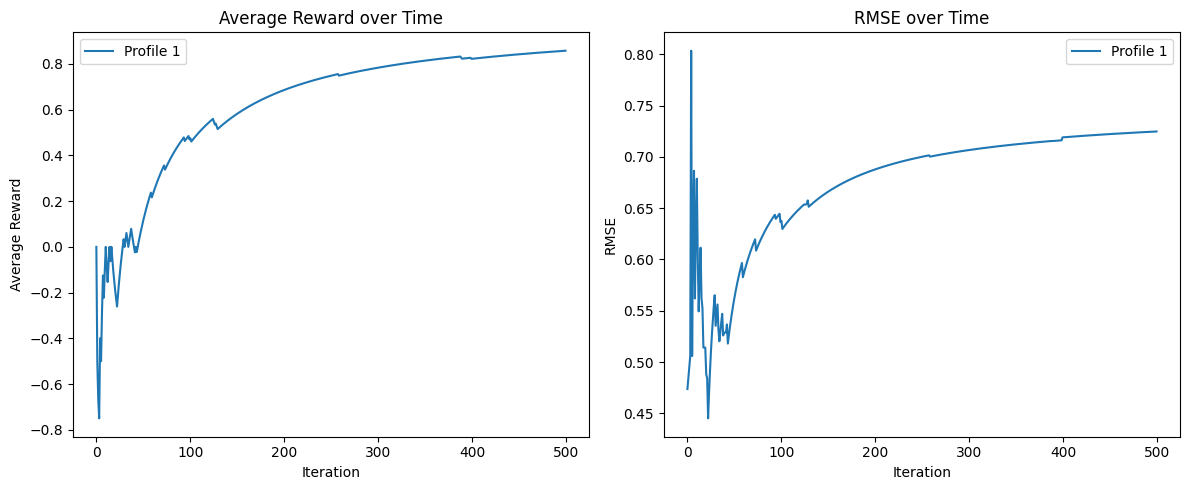

User profile with base change probability 0.49 and lambda fatigue 0.07
True values: -0.011031404416317558
Value estimates: [-0.4612938  -0.80353134 -0.74338798 -0.73376926 -0.77699683]
Action counts: N/A (SARSA agent does not keep track of action counts)


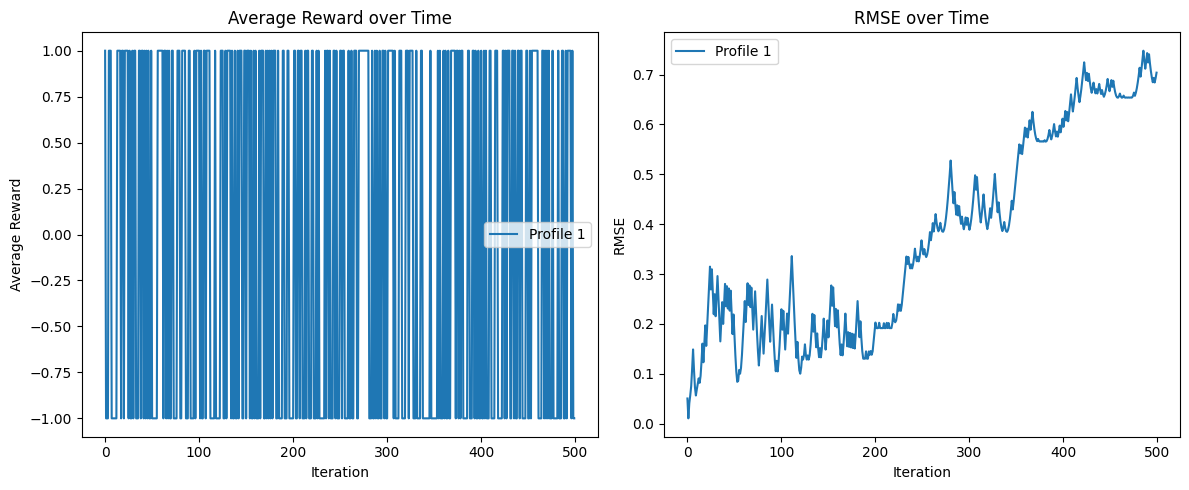

AttributeError: 'LinearFunctionApproximation' object has no attribute 'action_values'

In [1]:
import numpy as np
import tensorflow as tf
import tf_agents.environments as tf_env
import tf_agents.specs as tf_specs
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory

class FiveArmedBanditEnv(tf_env.py_environment.PyEnvironment):
    def __init__(self, user_model_vec, change_probability=0.3, lambda_fatigue=0.01, seed=42):
        self._num_actions = 5
        self._user_model_vec = user_model_vec
        self._change_probability = change_probability
        self._lambda_fatigue = lambda_fatigue
        self._step_count = 0
        self._total_reward = 0.0
        self._dummy_observation = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        np.random.seed(seed)
        super(FiveArmedBanditEnv, self).__init__()

    def action_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=self._num_actions - 1, name='action')

    def observation_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(self._num_actions,), dtype=np.float32, minimum=0, name='observation')

    def _reset(self):
        self._step_count = 0
        self._total_reward = 0.0
        return ts.restart(observation=self._dummy_observation)
    
    def _step(self, action):
        fatigue = 1 - np.exp(-self._lambda_fatigue * self._step_count)
        adjusted_change_probability = self._change_probability * (1 - fatigue)

        if np.random.uniform(0, 1) < adjusted_change_probability:
            self.current_state = 'changed_posture'
        else:
            self.current_state = 'same_posture'

        # Define rewards based on the state and action
        if self.current_state == 'changed_posture':
            reward = 1 if action != 4 else -1  # Positive reward for any action except 'stay'
        else:
            reward = -1 if action != 4 else 1  # Negative reward for any action except 'stay'

        self._step_count += 1
        self._total_reward += reward

        return ts.transition(observation=self._dummy_observation, reward=reward)
    
    def get_total_reward(self):
        return self._total_reward

    def get_step_count(self):
        return self._step_count


def generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range):
    user_profiles = []
    for _ in range(num_profiles):
        base_change_probability = np.random.uniform(*base_change_probability_range)
        lambda_fatigue = np.random.uniform(*lambda_fatigue_range)
        user_profiles.append((base_change_probability, lambda_fatigue))
    return user_profiles

class UCB1Agent:
    def __init__(self, num_actions, explore_rate=2.0):
        self.num_actions = num_actions
        self.explore_rate = explore_rate
        self.action_counts = np.zeros(num_actions)
        self.action_values = np.zeros(num_actions)
        self.total_steps = 0

    def select_action(self):
        ucb_values = self.action_values + self.explore_rate * np.sqrt(np.log(self.total_steps + 1) / (self.action_counts + 1))
        return np.argmax(ucb_values)

    def update_estimates(self, action, reward):
        self.total_steps += 1
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.action_values[action] += alpha * (reward - self.action_values[action])

    def get_current_average_reward(self):
        return np.sum(self.action_values * self.action_counts) / np.sum(self.action_counts)

class SARSA:
    def __init__(self, num_actions, lr=0.1, gamma=0.9):
        self.num_actions = num_actions
        self.lr = lr
        self.gamma = gamma
        self.action_values = np.zeros(num_actions)
        self.total_steps = 0

    def select_action(self, observation):
        return np.argmax(self.action_values)

    def update(self, observation, action, reward, next_observation, next_action):
        td_target = reward + self.gamma * self.action_values[next_action]
        td_error = td_target - self.action_values[action]
        self.action_values[action] += self.lr * td_error

class LinearFunctionApproximation:
    def __init__(self, num_actions, lr=0.1, gamma=0.9, state_dim=5):
        self.num_actions = num_actions
        self.lr = lr
        self.gamma = gamma
        self.state_dim = state_dim
        self.weights = np.zeros((num_actions, state_dim))
        self.total_steps = 0

    def select_action(self, observation):
        q_values = np.dot(self.weights, observation)
        return np.argmax(q_values)

    def update(self, observation, action, reward, next_observation, next_action):
        q_value = np.dot(self.weights[action], observation)
        td_target = reward + self.gamma * np.dot(self.weights[next_action], next_observation)
        td_error = td_target - q_value
        self.weights[action] += self.lr * td_error * observation

def user_simulation_UCB1(user_profiles, num_iterations=500, explore_rate=2.0):
    all_average_rewards = []
    all_rmse = []

    for base_change_probability, lambda_fatigue in user_profiles:
        # Create the environment
        env = FiveArmedBanditEnv(user_model_vec=None, change_probability=base_change_probability, lambda_fatigue=lambda_fatigue)

        # Create the UCB1 agent
        agent = UCB1Agent(num_actions=env.action_spec().maximum + 1, explore_rate=explore_rate)

        average_rewards = []
        rmse = []

        # Training loop
        for _ in range(num_iterations):
            # Main stepping
            action = agent.select_action()
            time_step = env.step(action)
            agent.update_estimates(action, time_step.reward)

            # Logs for plotting
            average_rewards.append(agent.get_current_average_reward())
            true_action_value = 2 * base_change_probability - 1
            rmse.append(np.sqrt(np.mean((np.subtract(agent.action_values, true_action_value))**2)))

        all_average_rewards.append(average_rewards)
        all_rmse.append(rmse)

        print(f"User profile with base change probability {base_change_probability:.2f} and lambda fatigue {lambda_fatigue:.2f}")
        print("True values: {}".format(true_action_value))
        print("Value estimates: {}".format(agent.action_values))
        print("Action counts: {}".format(agent.action_counts))

    return all_average_rewards, all_rmse

def user_simulation_SARSA(user_profiles, num_iterations=500, lr=0.1, gamma=0.9):
    all_average_rewards = []
    all_rmse = []

    for base_change_probability, lambda_fatigue in user_profiles:
        # Create the environment
        env = FiveArmedBanditEnv(user_model_vec=None, change_probability=base_change_probability)
        agent = SARSA(num_actions=env.action_spec().maximum + 1, lr=lr, gamma=gamma)
        
        average_rewards = []
        rmse = []

        # Training loop
        for _ in range(num_iterations):
            # Reset the environment at the start of each iteration
            time_step = env.reset()

            # Main stepping
            action = agent.select_action(time_step.observation)
            next_time_step = env.step(action)
            next_action = agent.select_action(next_time_step.observation)
            agent.update(
                observation=time_step.observation,
                action=action,
                reward=next_time_step.reward,
                next_observation=next_time_step.observation,
                next_action=next_action
            )

            # Logs for plotting
            average_rewards.append(env.get_total_reward() / env.get_step_count())
            true_action_value = 2 * base_change_probability - 1
            rmse.append(np.sqrt(np.mean((np.subtract(agent.action_values, true_action_value))**2)))

        all_average_rewards.append(average_rewards)
        all_rmse.append(rmse)

        print(f"User profile with base change probability {base_change_probability:.2f} and lambda fatigue {lambda_fatigue:.2f}")
        print("True values: {}".format(true_action_value))
        print("Value estimates: {}".format(agent.action_values))
        print("Action counts: N/A (SARSA agent does not keep track of action counts)")

    return all_average_rewards, all_rmse

def user_simulation_LFA(user_profiles, num_iterations=500, lr=0.1, gamma=0.9):
    all_average_rewards = []
    all_rmse = []

    for base_change_probability, lambda_fatigue in user_profiles:
        # Create the environment
        env = FiveArmedBanditEnv(user_model_vec=None, change_probability=base_change_probability)

        agent = LinearFunctionApproximation(num_actions=env.action_spec().maximum + 1, lr=lr, gamma=gamma)

        average_rewards = []
        rmse = []

        # Training loop
        for _ in range(num_iterations):
            # Main stepping
            time_step = env.reset()
            action = agent.select_action(time_step.observation)
            next_time_step = env.step(action)
            next_action = agent.select_action(next_time_step.observation)
            agent.update(
                observation=env.current_time_step().observation,
                action=action,
                reward=time_step.reward,
                next_observation=time_step.observation,
                next_action=next_action
            )

            # Logs for plotting
            average_rewards.append(env.get_total_reward() / env.get_step_count())
            true_action_value = 2 * base_change_probability - 1
            rmse.append(np.sqrt(np.mean((np.subtract(agent.action_values, true_action_value))**2)))

        all_average_rewards.append(average_rewards)
        all_rmse.append(rmse)

        print(f"User profile with base change probability {base_change_probability:.2f} and lambda fatigue {lambda_fatigue:.2f}")
        print("True values: {}".format(true_action_value))
        print("Value estimates: {}".format(agent.action_values))
        print("Action counts: N/A (LFA agent does not keep track of action counts)")
    return all_average_rewards, all_rmse

if __name__ == "__main__":
    num_profiles = 30 # We want enough profiles to see the variance in the results but not too many to stay feasible in the real experiment
    base_change_probability_range = (0.1, 0.5) # At minimum, the user changes posture 10% of the time and at maximum 50% of the time
    lambda_fatigue_range = (0.005, 0.1) # In the paper the values chosen were 0.01, 0.03 and 0.05
    
    # UCB1
    user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)
    average_rewards, rmse = user_simulation_UCB1(user_profiles)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    for i, (avg_rewards, rms) in enumerate(zip(average_rewards, rmse)):
        plt.subplot(1, 2, 1)
        plt.plot(avg_rewards, label=f'Profile {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('Average Reward')
        plt.title('Average Reward over Time')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(rms, label=f'Profile {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('RMSE')
        plt.title('RMSE over Time')
        plt.legend()

    plt.tight_layout()
    plt.show()


    # SARSA
    user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)
    average_rewards, rmse = user_simulation_SARSA(user_profiles)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    for i, (avg_rewards, rms) in enumerate(zip(average_rewards, rmse)):
        plt.subplot(1, 2, 1)
        plt.plot(avg_rewards, label=f'Profile {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('Average Reward')
        plt.title('Average Reward over Time')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(rms, label=f'Profile {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('RMSE')
        plt.title('RMSE over Time')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # LFA
    user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)
    average_rewards, rmse = user_simulation_LFA(user_profiles)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    for i, (avg_rewards, rms) in enumerate(zip(average_rewards, rmse)):
        plt.subplot(1, 2, 1)
        plt.plot(avg_rewards, label=f'Profile {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('Average Reward')
        plt.title('Average Reward over Time')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(rms, label=f'Profile {i+1}')
        plt.xlabel('Iteration')
        plt.ylabel('RMSE')
        plt.title('RMSE over Time')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
class QLearningAgent:
    def __init__(self, num_actions, num_states, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_decay=0.99):
        self.num_actions = num_actions
        self.num_states = num_states
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros((num_states, num_actions))
        self.action_counts = np.zeros((num_states, num_actions))
        self.total_steps = 0

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            action = random.randint(0, self.num_actions - 1)  # Explore
        else:
            action = np.argmax(self.q_table[state])  # Exploit
        return action

    def update_estimates(self, state, action, reward, next_state):
        self.total_steps += 1
        self.action_counts[state, action] += 1
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state, best_next_action]
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * td_error
        self.epsilon *= self.epsilon_decay  # Decay epsilon

    def get_current_average_reward(self):
        total_rewards = np.sum(self.q_table * self.action_counts)
        total_counts = np.sum(self.action_counts)
        return total_rewards / total_counts if total_counts != 0 else 0

# Example usage:
env = FiveArmedBanditEnv(user_model_vec)  # Assuming this is the environment from previous context
agent = QLearningAgent(num_actions=5, num_states=2)  # Two states: changed_posture and same_posture

num_episodes = 1000

for episode in range(num_episodes):
    time_step = env.reset()
    state = 0 if time_step.observation[-1] == 0.0 else 1
    done = False

    while not done:
        action = agent.select_action(state)
        time_step = env.step(action)
        reward = time_step.reward
        next_state = 0 if time_step.observation[-1] == 0.0 else 1
        agent.update_estimates(state, action, reward, next_state)
        state = next_state
        done = time_step.is_last()

    if episode % 100 == 0:
        avg_reward = agent.get_current_average_reward()
        print(f"Episode {episode}, Average Reward: {avg_reward}")

print("Trained Q-table:")
print(agent.q_table)